# 3D Plasmonic structure
The notebook is to simulate optical responses—Reflectance, Transmittance, and Absorbance of a 3D plasmonic biosensing in water. The plasmonic structure consists of Al nanoholes on homogeneous layers of SiO2, Si, and Ge. More details can be found in `Rigorous coupled-wave analysis of a multi-layered
plasmonic integrated refractive index sensor` by [Jon Schlipf and Inga A. Fischer, Optics express, 2021](https://opg.optica.org/oe/fulltext.cfm?uri=oe-29-22-36201)

The notebook presents two examples of simulating the multilayer plasmonic structure:
- The conventional approach: simulates the full global scattering matrix of the structure to quantify its optical responses.
- The bottom-up approach: simulates only half of the global scattering matrix to quantify the optical responses

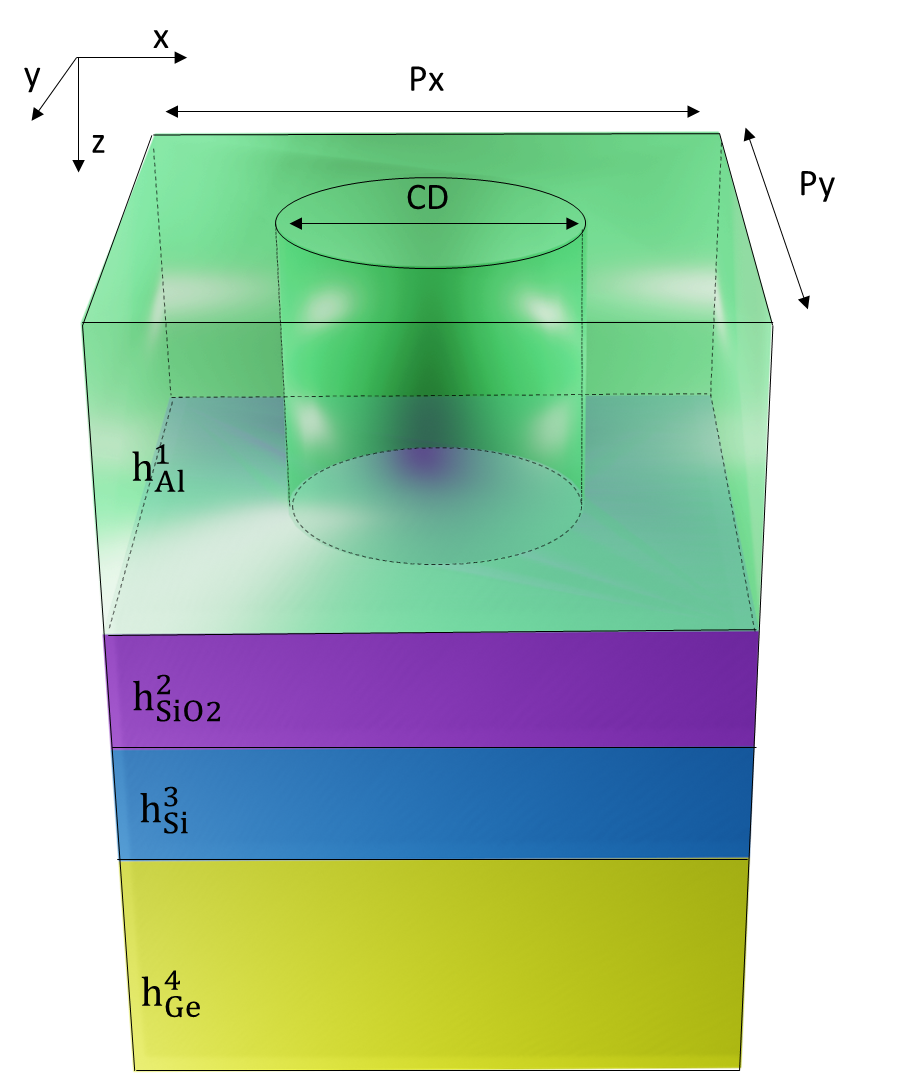

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import sys
path_parent=os.path.dirname(os.getcwd())
sys.path.insert(0,path_parent)

from src import ReadData
from src import rcwa
from src.Tools import vec2m

path_image=path_parent +"/image/plasmonic_sensor.png"
from IPython.display import Image
Image(filename=path_image,width=250)

## 1. Optical index: 

Make sure that eps have negative sign: eps=eps1-1j*eps2

In [2]:
# 1. read from database
path_optical_index=path_parent+'/dataNK/'
path_Si=path_optical_index+ 'c-Si_HJY_Modif.txt'
path_SiO2=path_optical_index+ 'SiO2_HJY_Modif.txt'
path_Al=path_optical_index+ 'Al_McPeak.txt'
path_Ge=path_optical_index+ 'Ge_Nunley.txt'

h=4.135667516*1e-15;#[eV s]      
c=299792458         #[m/s]

Si_wl, Si_nk=ReadData.read_nk(path_Si)
Si_wl=h*c/Si_wl*10**9      #eV to nm

SiO2_wl, SiO2_nk=ReadData.read_nk(path_SiO2)
SiO2_wl=h*c/SiO2_wl*10**9  #eV to nm

Al_wl, Al_nk=ReadData.read_nk(path_Al)
Al_wl=Al_wl*1000  # um to nm

Ge_wl, Ge_nk=ReadData.read_nk(path_Ge)
Ge_wl=Ge_wl*1000 # um to nm

# 2.Interpolate
wavelength_range=np.linspace(1000,1600,81) 
e_Si,e_SiO2,e_Al,e_Ge=ReadData.interpolate(wavelength_range,[Si_wl, Si_nk],[SiO2_wl, SiO2_nk],[Al_wl, Al_nk],[Ge_wl, Ge_nk])

#reflectance and transmittance zone
e_trn=np.copy(e_Si);  
e_ref=1.321**2 #water 

## 2. Input parameters

In [3]:
sim=rcwa()
sim.setup(wavelength_range=wavelength_range,
        LxLy=[950,950],              # periodic length [Lx,Ly]
        NxNy=[950,950],              # simulation domain [Nx,Ny]
        order=[5,5],                 # diffraction order [mx,my]
        angle=[0,0],                 # [AOI_d,Azimuth_d] in degree             
        e_ref=e_ref,                 # reflected medium
        e_trn=e_trn,                 # transmitted medium
        source='TM',                 # TM - x polarize, or TE- y polarized state                 
            )

## 3. Geometry: 

In [4]:
eps=[e_Al,e_SiO2,e_Si,e_Ge] 
eps_name=['Al','SiO2','Si','Ge']
h=[100.,50.,50.,1000.]

Structure=[]
NL=len(eps)
for lth in range(NL):
    layer=sim.Geometry.layer()     
    if lth ==0:
        mask=sim.Geometry.Circle(D=500) 
        layer['medium']={'eps':eps[lth],'h':h[lth],'eps_name':eps_name[lth]}
        layer['pattern']={'eps':e_ref, 'mask':mask,'eps_name':'water'}   
    else:
        layer['medium']={'eps':eps[lth],'eps_name':eps_name[lth],'h':h[lth]}  
    Structure.append(layer)  

C:\Users\hpham\Desktop\RCWA_numpy\src\Geometry.py:13: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


## 4. Visualization

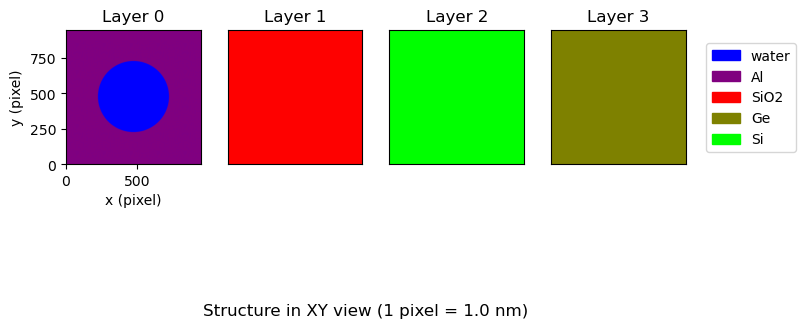

In [5]:
sim.Plot.XY(Structure,layer_position=[0,1,2,3])

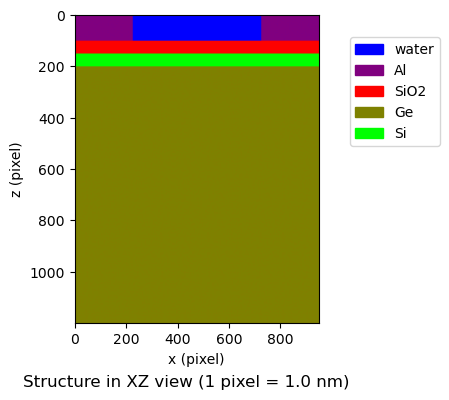

In [6]:
sim.Plot.XZ(Structure)

##  5. Simulation

### 5.1 Conventional

In [7]:
t0=time.time()
Ref=[];  Trn=[]
for wth in range(len(wavelength_range)): 
    
    #Scattering matrix    
    S_layer=sim.S_layer(Structure,idx=wth)    
    S_global=sim.S_System(S_layer)    
    
    # coefficients
    S_global_11=S_global[0];    S_global_21=S_global[2]; 
    rx,ry= sim.coeff(S_global_11)  
    tx,ty= sim.coeff(S_global_21)      
    
    # Ref and Trn
    R=sim.Reflectance(rx,ry)        
    Ref.append(np.sum(R))        
    
    T=sim.Transmittance(tx,ty)      
    Trn.append(np.sum(T))     

Ref=np.array(Ref)
Trn=np.array(Trn) 
#print(time.time() -t0)    

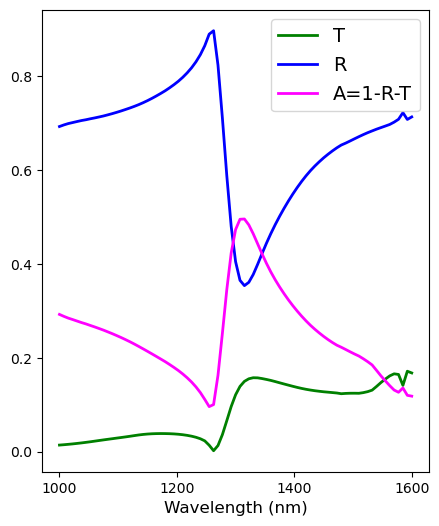

In [8]:
# View spectrum
fig_size=(5,6)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=fig_size)
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

ax.plot(wavelength_range,Trn,c='green',lw=2,label='T')
ax.plot(wavelength_range,Ref,c='blue',lw=2,label='R')
ax.plot(wavelength_range,1-Ref-Trn,c='magenta',lw=2,label='A=1-R-T')
ax.legend(loc="upper right")

ax.legend(prop=dict(size=14))

ax.set_xlabel('Wavelength (nm)',fontsize = 12.0)
plt.show()

###  5.2 Bottom-up

In [9]:
t0=time.time()
Ref=[];  Trn=[]
for wth in range(len(wavelength_range)):  
    
    S_layer=sim.S_layer(Structure,idx=wth,form='vector')  
    S_global_11,S_global_21=sim.S_System_bottom_up(S_layer,nb=3)  # nb: number of homogeneous bottom layer
    
    rx,ry= sim.coeff(S_global_11)  
    tx,ty= sim.coeff(S_global_21)      
    
    R=sim.Reflectance(rx,ry)        
    Ref.append(np.sum(R))        
    
    T=sim.Transmittance(tx,ty)      
    Trn.append(np.sum(T))     

Ref=np.stack(Ref)
Trn=np.stack(Trn) 

#print(time.time() -t0)  

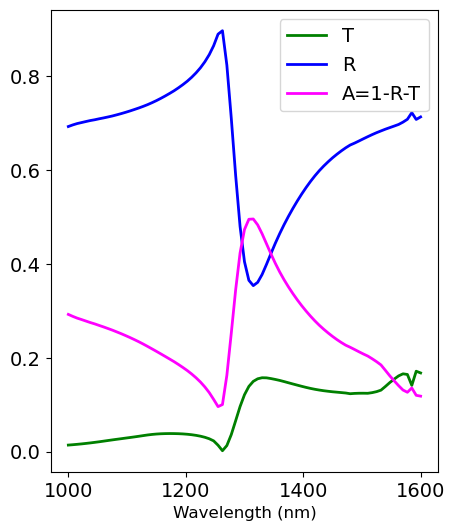

In [10]:
# View spectrum
fig_size=(5,6)
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=fig_size)
plt.rcParams['xtick.labelsize'] = 14 
plt.rcParams['ytick.labelsize'] = 14 

ax.plot(wavelength_range,Trn,c='green',lw=2,label='T')
ax.plot(wavelength_range,Ref,c='blue',lw=2,label='R')
ax.plot(wavelength_range,1-Ref-Trn,c='magenta',lw=2,label='A=1-R-T')
ax.legend(loc="upper right")

ax.legend(prop=dict(size=14))

ax.set_xlabel('Wavelength (nm)',fontsize = 12.0)
plt.show()